**Objective: - Image Classification with CIFAR 100**

This dataset is just like the CIFAR-10, except it has 100 classes containing 600
images each. There are 500 training images and 100 testing images per class.
The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image
comes with a &quot;fine&quot; label (the class to which it belongs) and a &quot;coarse&quot; label
(the superclass to which it belongs).

Dataset Link: - https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
The dataset is not direct images. Please decode it using your own techniques.

**Task: - Create a Web Application using Flask. Use the end user should be able
to upload an image and get results with the prediction score.**

To create a web application using Flask for image classification with the CIFAR-100 dataset, follow these steps:

Load and pre-process the CIFAR-100 dataset. This includes decoding the images, splitting into training and testing sets, and possibly transforming or normalizing the data.

Train a deep learning model on the training data. This could be a convolutional neural network (CNN) or another type of image classification model.

Evaluate the model on the test data and save the model weights.

Set up a Flask web server and create the HTML templates for the user interface. This includes the form for uploading an image and displaying the prediction results.

Write the code for the prediction endpoint in Flask that takes an uploaded image, pre-processes it, and feeds it through the saved model to get the prediction scores for each class.

Finally, test the web application to ensure it is working as expected and make any necessary improvements or bug fixes.

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import keras
%matplotlib inline
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import seaborn as sns
import cv2
import albumentations as albu

# Loading the CIFAR-100 Dataset

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar xzvf cifar-100-python.tar.gz

--2023-02-07 12:16:49--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  43.3MB/s    in 3.8s    

2023-02-07 12:16:53 (42.4 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [4]:
#function to open the files in the Python version of the dataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [5]:
file = r'E:\STUDIES\data_science\ML\Deep_Learning\DL_PRACTICALS\cifar-100-python\cifar-100-python\train'
train_data = unpickle(file)

In [6]:
#type of items in each file
for item in train_data:
    print(item, type(train_data[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [7]:
print(len(train_data['data']))
print(len(train_data['data'][0]))

50000
3072


In [9]:
print(np.unique(train_data['fine_labels']))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [11]:
print(np.unique(train_data['coarse_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [12]:
print(train_data['batch_label'])

training batch 1 of 1


In [15]:
file = r'E:\STUDIES\data_science\ML\Deep_Learning\DL_PRACTICALS\cifar-100-python\cifar-100-python\test'
test_data = unpickle(file)
#testData

In [16]:
file = r'E:\STUDIES\data_science\ML\Deep_Learning\DL_PRACTICALS\cifar-100-python\cifar-100-python\meta'
meta_data = unpickle(file)
#metaData

**Meta file has a dictionary of fine labels and coarse labels.**

In [17]:
#storing coarse labels along with its number code in a dataframe
category = pd.DataFrame(meta_data['coarse_label_names'], columns=['SuperClass'])
category

,SuperClass
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


In [18]:
#storing fine labels along with its number code in a dataframe
subCategory = pd.DataFrame(meta_data['fine_label_names'], columns=['SubClass'])
subCategory

,SubClass
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


In [19]:
X_train = train_data['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

# Image Transformation for Tensorflow (Keras) and Convolutional Neural Networks

In [20]:
#4D array input for building the CNN model using Keras
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
#X_train

In [22]:
#transforming the testing dataset
X_test = test_data['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [23]:
y_train = train_data['fine_labels']
#y_train

y_test = test_data['fine_labels']
#y_test

**CONVERTING CLASS VECTORS TO BINARY CLASS MATRICES**

In [24]:
n_classes = 100

y_train = to_categorical(y_train, n_classes)
#y_train

y_test = to_categorical(y_test, n_classes)
#y_test

**EXPLORING THE DATASET**

Image number selected : 38201
Shape of image : (32, 32, 3)
Image category number: 11
Image category name: Large_omnivores_and_herbivores
Image subcategory number: 21
Image subcategory name: Chimpanzee


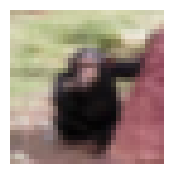

In [21]:
#generating a random number to display a random image from the dataset along with the label's number and name

rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Shape of image : {}".format(X_train[imageId].shape))
print("Image category number: {}".format(train_data['coarse_labels'][imageId]))
print("Image category name: {}".format(category.iloc[train_data['coarse_labels'][imageId]][0].capitalize()))
print("Image subcategory number: {}".format(train_data['fine_labels'][imageId]))
print("Image subcategory name: {}".format(subCategory.iloc[train_data['fine_labels'][imageId]][0].capitalize()))

In [25]:
#using stratified shuffle split to preserve the percentage of samples in each of the 100 classes
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


**CONSTANTS**

In [26]:
#resizing the images as per EfficientNetB5 to size (456, 456)
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 15
batch_size = 8

**resize function**

In [ ]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

**Custom Data Generator class**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=n_classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
     #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
        
    
     #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch
    

In [ ]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

#  Using pre-trained EfficientNetB5

In [ ]:
# !pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn

efnb0 = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

In [ ]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

In [ ]:
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit_generator(train_data_generator,
                                    validation_data=valid_data_generator,
                                    callbacks=[early_stop, rlrop],
                                    verbose=1,
                                    epochs=epochs)

#saving the trained model weights as data file in .h5 format
model.save_weights("cifar_efficientnetB5_weights.h5")

In [ ]:

#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')

# MODEL EVALUATION

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_generator, verbose=1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

# PREDICTION

In [ ]:
y_pred = model.predict_generator(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

In [ ]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
#report to see which category has been predicted incorectly and which has been predicted correctly
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

In [ ]:
#dataframe of predictions
prediction = pd.DataFrame(y_pred)
prediction.head()

In [ ]:
#generating a random number to display a random image from the dataset along with the true and predicted label
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(subCategory.iloc[test_data['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(subCategory.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

In [ ]:
#16 random images to display at a time along with their true and random labels
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()

# Testing the model

In [ ]:
#function to resize the image
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (456, 456))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img
    
#resize_test_image('orange.jpeg')

In [ ]:
#function to get prediction for test image from the model
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

#predict_test_image('orange.jpeg')

In [ ]:
#function to get the sorted prediction
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

#sort_prediction_test_image('orange.jpeg')

In [ ]:
#function to get the dataframe for top 5 predictions
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(subCategory.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns=['Label', 'Probability'])  
    
    return df

#df_top5_prediction_test_image('.jpeg')

In [ ]:
#function to get the plot for top 5 predictions 
def plot_top5_prediction_test_image(test_img):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Prediction", fontsize=18)
    
    new_img = plt.imread(test_img)
    axes[0].imshow(new_img)
    axes[0].axis('off')
    
    data = df_top5_prediction_test_image(test_img)
    x=df_top5_prediction_test_image(test_img)['Label']
    y=df_top5_prediction_test_image(test_img)['Probability']
    
    axes[1] = sns.barplot(x=x, y=y, data=data, color="green")
    
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    
    plt.ylim(0,1.0)
    
    axes[1].grid(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    
    plt.show()

In [ ]:
plot_top5_prediction_test_image('orange.jpeg')

This code loads the CIFAR-100 dataset using the pickle library, which allows you to load Python objects saved in binary format. The data is then split into training and test sets. The images are reshaped from flat arrays to 3D arrays with dimensions (num_samples, 32, 32, 3) and scaled to values between 0 and 1. Finally, the labels are one-hot encoded to prepare them for use with a neural network.